# Camera Calibration with Multiple Chessboard Patterns

Camera calibration using images of different chessboard patterns:
1. First chessboard: 10×7 squares (9×6 inner corners), square size = 2.5 cm
2. Second chessboard: 10×8 squares (9×7 inner corners), square size = 2.0 cm

Official OpenCV tutorial: https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html
##### Distortion coefficients:
$$D = (k_1 \quad k_2 \quad p_1 \quad p_2 \quad k_3)$$

##### Camera matrix:
$$K = \begin{bmatrix} 
f_x & 0 & c_x \\
0 & f_y & c_y \\
0 & 0 & 1
\end{bmatrix}$$

In [2]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt

def camera_calibration(images_path, board_size, square_size, output_folder="../data/"):
    """
    Camera calibration function that handles different chessboard sizes and configurations.
    
    Parameters:
    -----------
    images_path : str
        Path to the folder containing calibration images
    board_size : tuple
        The inner corners of the chessboard pattern as (width, height)
    square_size : float
        The size of each square in the chessboard (in cm or mm)
    output_folder : str
        Path to save the calibration results (K.txt and D.txt)
        
    Returns:
    --------
    K : numpy.ndarray
        Camera matrix (3x3)
    D : numpy.ndarray
        Distortion coefficients
    """
    # Create output folder if it does not exist
    os.makedirs(output_folder, exist_ok=True)
    
    # Termination criteria for cornerSubPix algorithm
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    
    # Prepare object points based on the chessboard size
    # Like (0,0,0), (1,0,0), (2,0,0) ... etc. in world coordinate system
    objp = np.zeros((board_size[0] * board_size[1], 3), np.float32)
    
    # Fill in x,y coordinates, z remains 0 (assuming chessboard is on a flat surface)
    # Scale by square_size to get actual world coordinates in mm or cm
    objp[:, :2] = np.mgrid[0:board_size[0], 0:board_size[1]].T.reshape(-1, 2) * square_size
    
    # Arrays to store object points and image points
    objpoints = []  # 3D points in real world space
    imgpoints = []  # 2D points in image plane
    
    # Load images
    images = glob.glob(os.path.join(images_path, '*.jpg'))
    
    if len(images) == 0:
        # if no jpg files found
        images = glob.glob(os.path.join(images_path, '*.png'))
        if len(images) == 0:
            raise ValueError(f"No images found in {images_path}")
    
    print(f"Found {len(images)} images for calibration")
    
    found = 0
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        if img is None:
            print(f"Failed to read image: {fname}")
            continue
        
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, board_size, None)
        
        # If corners are found, add object points and refined image points
        if ret:
            objpoints.append(objp)
            
            # Refine corner positions
            corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            imgpoints.append(corners2)
            
            # Draw the corners on the image
            img_corners = img.copy()
            cv2.drawChessboardCorners(img_corners, board_size, corners2, ret)
                    
            # For visualization, show a sample of first successful image
            if found == 0:
                plt.figure(figsize=(10, 8))
                plt.imshow(cv2.cvtColor(img_corners, cv2.COLOR_BGR2RGB))
                plt.title('Detected Corners')
                plt.axis('off')
                plt.tight_layout()
                plt.savefig(os.path.join(output_folder, 'corner_detection.png'))
            found += 1
    
    plt.show()
    
    print(f"\nCalibration performed using {found} images")
    
    if found == 0:
        raise ValueError("No chessboard corners detected in any image. Check your board_size parameter.")
    
    # Perform camera calibration
    ret, K, D, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    # Save calibration results
    np.savetxt(os.path.join(output_folder, 'K.txt'), K)
    np.savetxt(os.path.join(output_folder, 'D.txt'), D)
    
    # Visualization of the calibration results
    # Calculate reprojection error
    mean_error = 0
    for i in range(len(objpoints)):
        imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], K, D)
        error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
        mean_error += error
    print(f"\nMean reprojection error: {mean_error/len(objpoints)}")
    
    return K, D

#### First Chessboard: 10×7 squares (9×6 inner corners), square size = 2.5 cm

Found 55 images for calibration


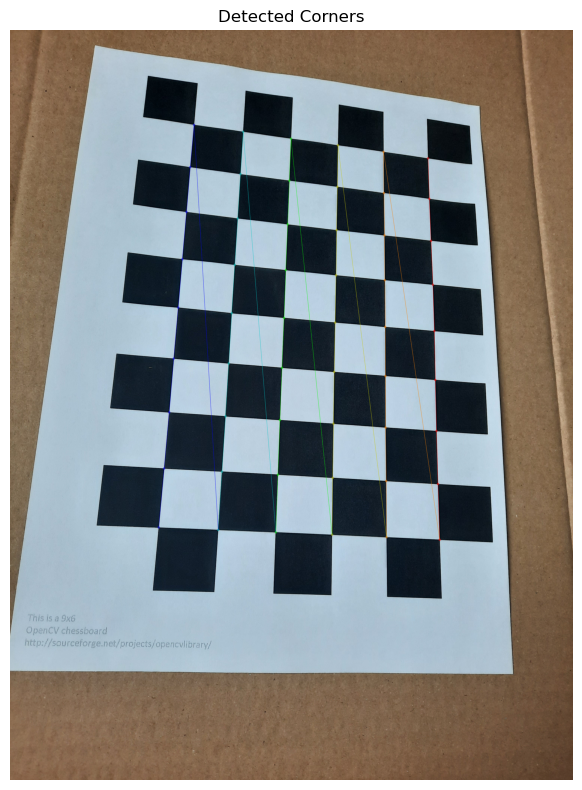


Calibration performed using 51 images

Mean reprojection error: 0.28163870701299565

Calibration results for the first chessboard:
Camera Matrix (K):
[[2.98997418e+03 0.00000000e+00 1.45869148e+03]
 [0.00000000e+00 2.99624353e+03 2.01082644e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion Coefficients (D):
[[ 6.03600424e-02 -2.03224473e-01  1.54507639e-03 -6.22446203e-06
   1.32428953e-01]]


In [3]:
# Parameters for the first chessboard
images_path1 = '../data/images/chessboard1/'
board_size1 = (9, 6)  # 9×6 inner corners
square_size1 = 2.5    # 2.5 cm per square
output_dir = '../data/calibration_parameters/'
os.makedirs(output_dir, exist_ok=True)

K1, D1 = camera_calibration(images_path1, board_size1, square_size1, output_dir)

print("\nCalibration results for the first chessboard:")
print("Camera Matrix (K):")
print(K1)
print("\nDistortion Coefficients (D):")
print(D1)

#### Second Chessboard: 10×8 squares (9×7 inner corners), square size = 2 cm

Found 59 images for calibration


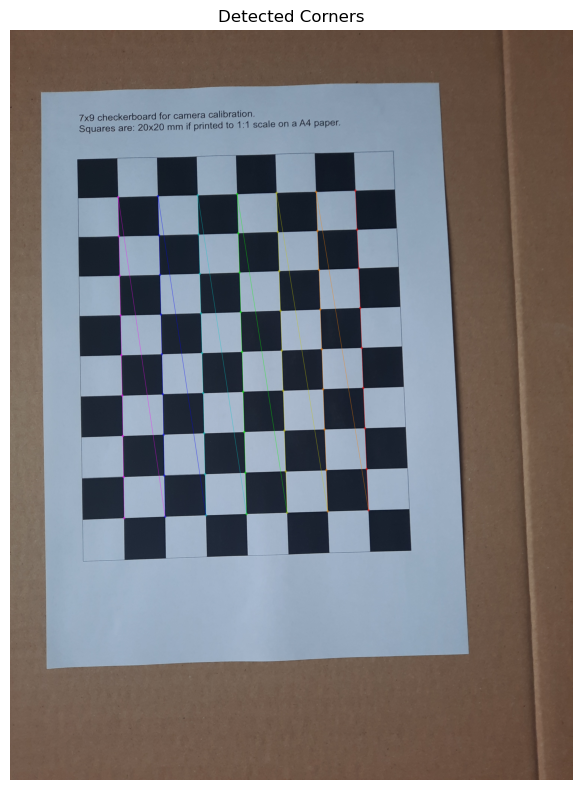


Calibration performed using 59 images

Mean reprojection error: 0.24598646959310697

Calibration results for the second chessboard:
Camera Matrix (K):
[[2.94546698e+03 0.00000000e+00 1.47463293e+03]
 [0.00000000e+00 2.94789214e+03 1.97712242e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion Coefficients (D):
[[ 0.07580619 -0.27997278  0.00050411  0.00136786  0.34313621]]


In [4]:
# Parameters for the second chessboard
images_path2 = '../data/images/chessboard2/'
board_size2 = (9, 7)  # 9×7 inner corners
square_size2 = 2.0    # 2.0 cm per square
output_dir = '../data/calibration_parameters2/'
os.makedirs(output_dir, exist_ok=True)

K2, D2 = camera_calibration(images_path2, board_size2, square_size2, output_dir)

print("\nCalibration results for the second chessboard:")
print("Camera Matrix (K):")
print(K2)
print("\nDistortion Coefficients (D):")
print(D2)